In [2]:
#!/usr/bin/env python3
# coding: utf-8

# Load dependencies
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

# For interactive plots, install `plotly`
import plotly.express as px
# pd.options.plotting.backend = "plotly"

# Load the data from the Varennes NetZEB Library
Column descriptions:

    # Temperatures
    'T_ext': exterior temp, C
    'T_int': average interior temp, C
    'T_slab: slab temperature, 2 inch from surface, C
    'T_room_air_over_slab': average room temperature over the slab where there is a radiant system, C
    'T_room_air_no_slab': same but where there isn't, C

    # BIPV/T System
    'BIPVT_outletT': temperature at BIPV/T outlet, C
    'BIPVT_dT': ^ minus T_ext, K
    'BIPVT_heat: m*cp*dT = fanstate*rated_flow*density*cp*dT, kW

    # Heating/Cooling
    'geo_heat': m*cp*dT at the geothermal well inlet: how much heat are we rejecting/extracting into the ground, kW
    'heating_total': m*cp*dT at the heat pump condensor/hot side, kW
    'cooling_total': evaporator/cold side, kW
    'Q_slab': heat going into the radiant slab, kW
    'Q_rest_heating': heat going into the air, kW
    'Q_rest': heat - cooling going into the air, kW
    'heating_slab_ratio': heating going into slab over total, rest goes into the air
    'cooling_slab_ratio': cooling going into slab over total, rest goes into the air

    # Windows
    'window_state: 0: closed, 1: open

    # Solar
    'DNI': direct normal irradiance, kW/m^2
    'GHI': global horizontal irradiance, kW/m^2
    'DHI': diffuse horizontal irradiance, kW/m^2
    'solar_projected_PV': unitized solar radiation incident on PV system, kW/m^2

    # Electrical
    'cons': total electrical consumption power, kW
    'prod: total electrical production power, kW
    'cons_noHVAC': approximate electrical consumption without the HVAC (cons - heating_total/4 - cooling_total/3.5), kW

In [3]:
# Load data from csv file, assign index and assure it's a datetime object
df = pd.read_csv("data_varennes_subset.csv.zip", index_col=[0], parse_dates=[0])
print(df.head())

                       T_ext    T_int  BIPVT_outletT  BIPVT_dT  BIPVT_heat  \
Datetime                                                                     
2018-01-01 00:00:00 -21.8566  18.4578       -18.6184    3.2382         0.0   
2018-01-01 00:15:00 -21.8434  18.4086       -18.6614    3.1820         0.0   
2018-01-01 00:30:00 -21.9561  18.3142       -18.6459    3.3102         0.0   
2018-01-01 00:45:00 -22.0408  18.2528       -18.7473    3.2935         0.0   
2018-01-01 01:00:00 -22.1299  18.1697       -18.6353    3.4946         0.0   

                      geo_heat  heating_total  cooling_total  window_state  \
Datetime                                                                     
2018-01-01 00:00:00 -54.118034      38.025668            0.0      0.335996   
2018-01-01 00:15:00 -50.619191      26.322083            0.0      0.336057   
2018-01-01 00:30:00  -9.066210      13.017722            0.0      0.336118   
2018-01-01 00:45:00 -37.896533      10.618306            0.0   

# Approach
Here, we will try to use our domain expertise to see whether we can notice certain trends.

In [3]:
# Define our dependent/independent variables
state_columns = ["T_int"]
control_columns = ["heating_total"]
exogenous_columns = ["T_ext", "cons_noHVAC", "GHI"]

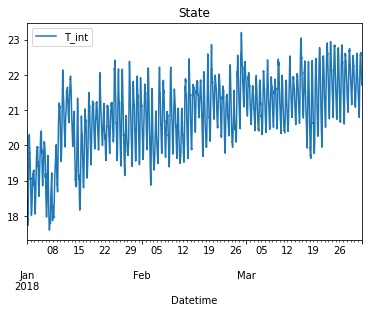

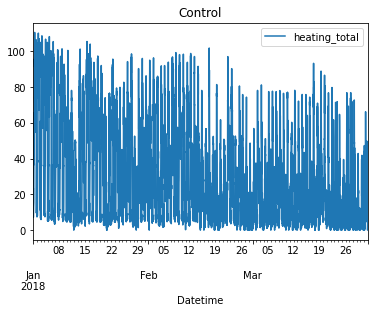

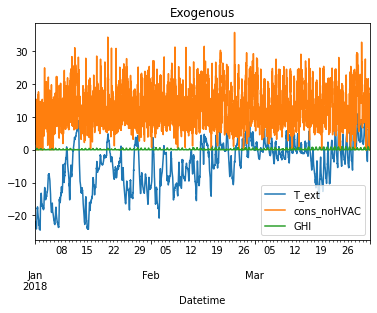

In [15]:
# Plot timeseries
df[state_columns].plot(title="State")
df[control_columns].plot(title="Control")
df[exogenous_columns].plot(title="Exogenous");

In [21]:
# Interactive plot
px.line(df[state_columns])

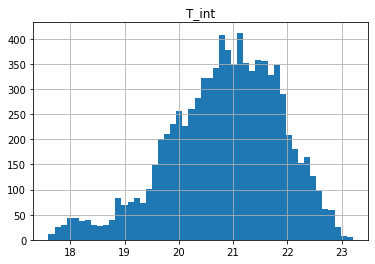

In [16]:
# Temperature distribution
df[state_columns].hist(bins=50);

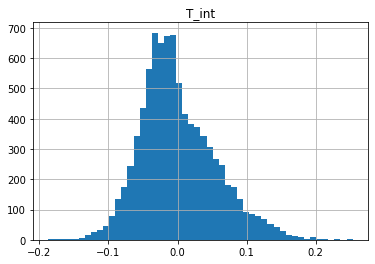

In [17]:
# T(t+1)-T(t) distribution
df[state_columns].diff().hist(bins=50);

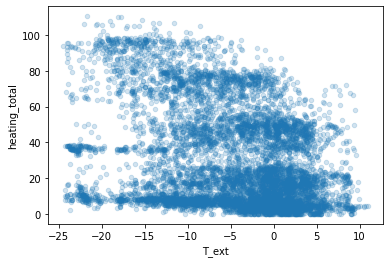

In [18]:
# Relationship between T_ext and heating
df.plot.scatter(x='T_ext', y='heating_total', alpha = 0.2);  # using matplotlib backend
# df.plot.scatter(x='T_ext', y='heating_total', opacity = 0.2)  # using plotly backend
# df.plot.hexbin(x='T_ext', y='heating_total', gridsize=20)  # scatter points summed in a hex bin

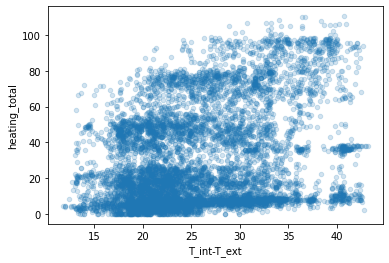

In [19]:
# Relationship between (T_int - T_ext) and heating
df["T_int-T_ext"] = df["T_int"] - df["T_ext"]  # larger means much colder
df.plot.scatter(x='T_int-T_ext', y='heating_total', alpha = 0.2);
# df.plot.scatter(x='T_int-T_ext', y='heating_total', opacity = 0.2)

In [22]:
# Let's check at night vs day using `plotly`
mask = (df.index.hour < 7) | (df.index.hour > 21)
df["is_night"] = mask

fig = px.scatter(df, x="T_int-T_ext", y="heating_total", color = "is_night", trendline="ols", opacity=0.2)
fig.show()

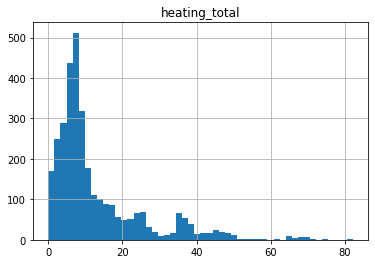

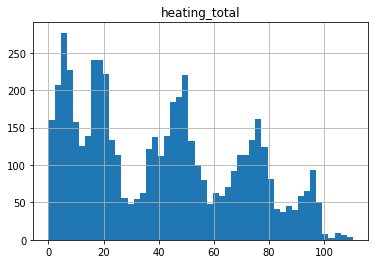

In [14]:
# `heating_total` distribution
df[mask][control_columns].hist(bins=50)
df[~mask][control_columns].hist(bins=50);

In [128]:
# Draw a vector field: Q vs T_ext-T_int where vector == dT_int

# Add the columns we need for this analysis
df["dT_int"] = df["T_int"].diff()
df["T_int-T_ext"] = df["T_int"] - df["T_ext"]  # larger means much colder

# T_int-T_ext bins
dx = 10
T_int_T_ext_bins = np.linspace(10,50,dx)
T_int_T_ext_center = T_int_T_ext_bins[:-1] + (T_int_T_ext_bins[1]-T_int_T_ext_bins[0])/2
T_int_T_ext_labels = [str(i) for i in T_int_T_ext_center]
df["T_int-T_ext_bin"] = pd.cut(df["T_int-T_ext"], T_int_T_ext_bins, labels = T_int_T_ext_labels)

# Heating bins
dy = 10
heating_bins = np.linspace(0,110,dy)
heating_center = heating_bins[:-1] + (heating_bins[1]-heating_bins[0])/2
heating_labels = [str(i) for i in heating_center]
df["heating_total_bin"] = pd.cut(df["heating_total"], heating_bins, labels = heating_labels)

# Pivot table
df_pivot_mean = pd.pivot_table(df, values="dT_int", index="heating_total_bin", columns="T_int-T_ext_bin", dropna=False, aggfunc="mean")
df_pivot_count = pd.pivot_table(df, values="dT_int", index="heating_total_bin", columns="T_int-T_ext_bin", dropna=False, aggfunc="count")

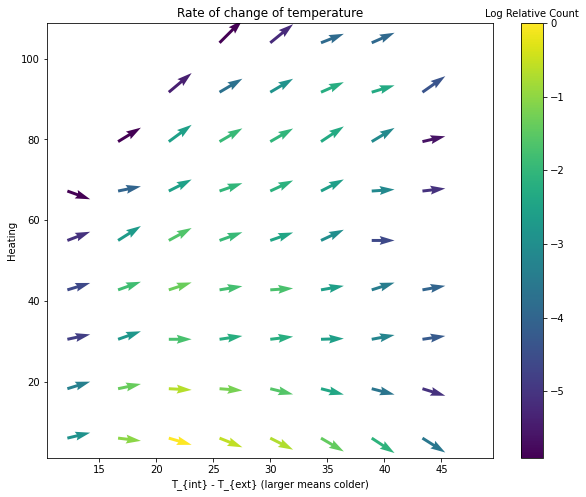

In [130]:
# Direction based on mean
x, y = np.meshgrid(T_int_T_ext_center, heating_center)
v = df_pivot_mean.values
u = df_pivot_mean.max().max()

# Colour based on count
# c = df_pivot_count.values / df_pivot_count.max().max()
# cbar_title = "Relative Count"
c = np.log(df_pivot_count.values / df_pivot_count.max().max())
cbar_title = "Log Relative Count"

# Quiver plot
plt.figure(figsize=(10,8))
plt.quiver(x, y, u, v, c, cmap=plt.cm.viridis)
plt.xlabel("T_{int} - T_{ext} (larger means colder)")
plt.ylabel("Heating")
cbar = plt.colorbar()
cbar.ax.set_title(cbar_title, fontsize=10)
# plt.xlim(10, 45)
# plt.ylim(-5, 110)
plt.title("Rate of change of temperature")
plt.show()

## Conclusion
+ Anything interesting between the distributions of temperature vs rate of change of temperature? What would you expect to see in a 1-year dataset?
+ Is there an obvious relationship between exterior temperature and heating? Explain.
+ Do you notice anything in particular for the heating?
